# Individual based modelling - mortality

Particle tracking models are often extended to simulate autonomous or living entities. A model of this type is often referred to as an individual based model (IBM). In IBMs, particles are imbued with the qualities of living entities, and may grow, move autonomously, reproduce or die.  Infrastructure that supports the simulation of basic living entities has been implemented in PyLag. Here, it is demonstrated in a model of *particle mortality*. The approach might be applied to the simulation of pathogens entering the ocean from land, which slowly die off over time. The example uses the same physical setup as was described and used in the [FVCOM forward tracking experiment](./fvcom_forward_tracking.ipynb). A detailed description of the different mortality calculators implemented in PyLag can be found [here](../documentation/mortality.ipynb).

As in the other examples, we first ensure paths to the relevant input data have been set.

In [1]:
import warnings
import os

warnings.filterwarnings('ignore')


# Root directory for PyLag example input files
data_dir='{}/data/pylag_doc'.format(os.environ['HOME'])

# Grid metrics file
grid_metrics_file_name = '{}/fvcom_tamar_estuary_grid_metrics.nc'.format(data_dir)

## Simulation input data

We create the initial positions file in the same as before.

In [2]:
import matplotlib

from pylag.processing.coordinate import utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group


# Ensure inline plotting
%matplotlib inline

# Keep a copy of the cwd
cwd = os.getcwd()

# Create run directory
simulation_dir = '{}/simulations/mortality'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# The group ID of this particle set
group_id = 1

# Lat and lon coordiantes for the centre of the release zone
lat = 50.32
lon = -4.17

# Convert to UTM coordinates
easting, northing, _ = utm_from_lonlat([lon], [lat], zone='30N')

# Release zone radius (m)
radius = 200.0

# Target number of particles to be released. Only a target,
# since we are evenly distributing particles in the release
# zone, which has no unique solution.
n_particles_target = 100

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [easting, northing],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = False)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Output filename
file_name = '{}/initial_positions.dat'.format(input_dir)

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           surface_release_zone.get_eastings(),
                                           surface_release_zone.get_northings(),
                                           surface_release_zone.get_depths())

The process of creating the grid metrics file is described in the earlier examples and is not repeated here. Rather, we use the grid metrics file provided with the example data.

## Creating the run configuration file

The run configuration file for running PyLag as an IBM includes a number of extra sections and options compared with a configuration file that is used simply for modelling particle transport. Those that are specific to simulating mortality are described [here](../documentation/mortality.ipynb). For this example, a run configuration file has been provided. The physical and run parameters are the same as those used in the FVCOM forward tracking experiment. Parameters specific to the calculation of mortality are as follows:

In [3]:
import configparser

config_file_name = './configs/mortality_template.cfg'

cf = configparser.ConfigParser()
cf.read(config_file_name)

print('Biological parameters')
print('---------------------\n')

print('BIO_MODEL: {}\n'.format(cf.get('BIO_MODEL', 'use_bio_model')))
print('mortality_calculator: {}\n'.format(cf.get('BIO_MODEL', 'mortality_calculator')))
print('death_rate_per_day: {}\n'.format(cf.get('PROBABILISTIC_MORTALITY_CALCULATOR', 'death_rate_per_day')))

Biological parameters
---------------------

BIO_MODEL: True

mortality_calculator: probabilistic

death_rate_per_day: 1.0



The above options say that we are running with biological processes (`BIO_MODEL` is `True`), and that mortality will be calculated probabilistically using a specified death rate of 0.1 d$^{-1}$. Before we can run the model, we need to set `data_dir` in the config, and point the model at the grid metrics file we will use. We do this below, then save the config in the simulation directory.

In [4]:
cf.set('OCEAN_CIRCULATION_MODEL', 'data_dir', data_dir)
cf.set('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file', grid_metrics_file_name)

# Save a copy in the simulation directory
with open("{}/pylag.cfg".format(simulation_dir), 'w') as config:
    cf.write(config)

## Running the model

With the run configuration file saved, we can now run the example. While PyLag can be used interactivatly, it is most commonly launched from the command line. A small driver script has been provided, which we will use here to launch *PyLag*.

In [5]:
import subprocess

# Change to the run directory and launch
os.chdir('{}'.format(simulation_dir))

try:
    subprocess.call(['./run.sh'])
except:
    print('Run failed.')
    pass

# Return to the cwd
os.chdir(cwd)

## Visualising the result

With the model having run, the final step is to visulise the result. Here, we produce a simple plot of particle pathlines up to the time when they died. These are overlaid on top of the bathymetry for the domain. As in previous examples, we leverage plotting functionality within the `pylag.processing` subpackage.

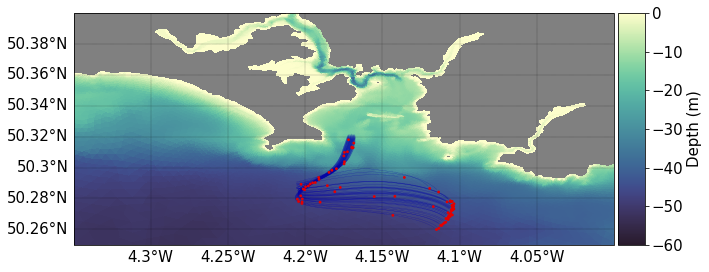

In [17]:
import numpy as np
from netCDF4 import Dataset
import cartopy.crs as ccrs
from datetime import timedelta

from pylag.processing.plot import create_figure, colourmap
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.ncview import Viewer

# Plot extents
extents = np.array([-4.35, -4.0, 50.25, 50.4], dtype=float)

# Create the figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)


# Read in the bathymetry and plot. We'll overlay pathlines on top of this.
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
del(ds)

plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                   vmin=-60., vmax=0., cmap=cmap)

# Output file name
file_name = '{}/output/pylag_1.nc'.format(simulation_dir)

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=900)

# Scatter the location of each particle and its pathline up until the time when it died.
for particle_index in range(n_particles):
    # Get age or death time index
    time_index = np.argmax(viewer('is_alive')[:, particle_index]==0)
    
    # If time_index is `0`, the particle is still alive. Set the index to -1 to plot the full path.
    if time_index == 0:
        time_index = -1
    
    # Convert positions into lons/lats
    lons, lats = lonlat_from_utm([viewer('x')[time_index, particle_index].squeeze()],
                                 [viewer('y')[time_index, particle_index].squeeze()], zone='30N')

    # Plot particle final positions
    ax, scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='none')

    # Convert all pathline coordinates into lons/lats
    lons_paths, lats_paths = lonlat_from_utm([viewer('x')[:time_index, particle_index].squeeze()],
                                             [viewer('y')[:time_index, particle_index].squeeze()], zone='30N')

    # Add path lines
    ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.15, alpha=1, color='#0504aa')

In the plot we can see particles moving out into the centre of the channel, as also shown in the [FVCOM forward tracking experiment](./fvcom_forward_tracking.ipynb). However, here some particles are seen to die off as they away from the release zone. The red dots mark either the position where the particle died or its final position at the end of the simulation (not all particles have died by the end of the simulation).